<div style="text-align: center;">
<a target="_blank" href="https://colab.research.google.com/github/bmalcover/aa_2425/blob/main/08_AlexNet_Transfer/Solucio/AlexNet_Transfer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

In [1]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, models, transforms


# Models ja existents i *transfer learning*

En aquesta pràctica, aprofundirem en la classificació d’imatges amb xarxes neuronals convolucionals (CNNs), però amb un enfocament diferent al de la sessió anterior. Mentre que anteriorment vàrem construir CNNs des de zero per comprendre la seva estructura bàsica, aquest cop treballarem amb un model de CNN preentrenat: **AlexNet**. Els objectius són:

- **Comprendre i utilitzar un model existent**: en aquest cas, AlexNet, un model ja entrenat sobre un gran conjunt de dades.
- **Transfer Learning**: aprendre com aprofitar els coneixements d’una xarxa preentrenada i adaptar-la per resoldre una nova tasca.
- **Càrrega de conjunts de dades d’imatges locals**: aplicar el processament d’imatges i la càrrega de dades des de l’ordinador.

Aquest enfocament ajuda a optimitzar l’entrenament i és especialment útil quan es disposa de pocs recursos computacionals o un conjunt de dades més reduït.

### AlexNet

AlexNet és una xarxa que va establir un nou estàndard en visió per computador gràcies a la seva capacitat de reconeixement en múltiples categories. La seva estructura, composta de capes convolucionals i de max-pooling, amb capes totalment connectades al final, és una referència en el camp de les CNNs.

Aquest cop, usarem AlexNet com a punt de partida, sense construir el model des de zero, per veure com es poden reutilitzar i adaptar les seves característiques apreses per a nous conjunts de dades.

### Què és el Transfer Learning?

El Transfer Learning és una tècnica que permet aprofitar les xarxes preentrenades (com AlexNet) per a una nova tasca. La xarxa es modifica per adaptar-la a les noves classes del conjunt de dades que volem classificar, fent ús de les característiques generals ja apreses en l’entrenament inicial (vores, textures, etc.).

Aquest process es pot fer de dues maneres. La primera és el que també rep el nom de **fine-tunning**:
- Congelarem les primeres capes del model per conservar les característiques generals apreses.
- Modificarem i entrenarem només les capes finals per adaptar-les a les noves classes, fent que el model s’ajusti de forma ràpida i amb menys dades.

La segona, que anomenam també com la categoria general **transfer learning**:

- Congelarem les capes de l'extractor de característiques del model per conservar les característiques generals apreses.
- Afegir un nou classificador ``MLP`` i entrenar-ho de 0.


Aquest procediment permetrà entendre com es pot utilitzar una xarxa ja existent per resoldre tasques específiques sense haver de construir ni entrenar un model completament des de zero.

### Guia de la Pràctica

En aquest notebook treballarem per:

 1. Carregar i preparar un conjunt d’imatges des de l’ordinador.
 2. Utilitzar el model AlexNet preentrenat i aplicar transfer learning per ajustar-lo a noves categories.
 3. Analitzar el rendiment del model i visualitzar els resultats.

## Començam

Primer de tot, com sempre, hem d'obtenir les dades. Aquesta sessió la farem amb el conjunt de dades [Tiny ImageNet](https://www.kaggle.com/c/tiny-imagenet/data?select=train.images.zip). 

Aquest conjunt de dades es defineix en la seva plana de la forma següent:

> MicroImageNet classification challenge is similar to the classification challenge in the full ImageNet ILSVRC. MicroImageNet contains 200 classes for training. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 colored ones.

Aquesta vegada no farem feina amb un conjunt de dades ja existents a ``torchvision`` sinó que nosaltres farem la gestió des de 0. Per tant i primer de tot descarregarem les dades. Per fer-ho podem trobar el conjunt de dades a la següent plana (http://cs231n.stanford.edu/tiny-imagenet-200.zip).

Alternativament també podem emprar l'eina ``wget`` així:

```
wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
```

Una vegada que hem descarregat les dades les podem descomprimir i finalment comença a fer-hi feina.

In [2]:
BATCH_SIZE = 4
EPOCHS = 5

transform = transforms.Compose([
    transforms.ToTensor(),
])

train = datasets.ImageFolder('tiny-imagenet-200/train', transform=transform)
test = datasets.ImageFolder('tiny-imagenet-200/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

L'estructura ``ImageFolder`` de PyTorch és una classe de ``torchvision.datasets`` que permet carregar un conjunt de dades d'imatges estructurat en carpetes, on cada subcarpeta representa una classe. És útil per a projectes de classificació d'imatges, ja que facilita la lectura automàtica d'imatges i etiquetes a partir de la seva organització en el sistema de fitxers.

### Estructura de carpetes
L'estructura que requereix ``ImageFolder`` per funcionar és la següent:

```
dataset_root/
├── class1/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── class2/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
└── classN/
    ├── image1.jpg
    ├── image2.jpg
    └── ...
```

On cada subcarpeta dins de dataset_root té el nom d'una classe, i dins de cada subcarpeta hi ha les imatges corresponents a aquella classe.

#### Com funciona ImageFolder

1. Etiquetes automàtiques: ImageFolder assigna una etiqueta numèrica a cada carpeta (classe) seguint l'ordre alfabètic dels noms de les carpetes.
2. Transformacions: Pots afegir transformacions com ToTensor, Resize, Normalize, etc., per pre-processar les imatges en el moment de carregar-les.
3. Dades i etiquetes: Cada vegada que crides un element del dataset, ImageFolder retorna una tupla (imatge, etiqueta).

Aquest mètode és molt eficient per carregar i estructurar imatges per a tasques de classificació i facilita la integració amb models de PyTorch com AlexNet, ResNet, etc.


In [3]:
img, target = next(iter(train_loader))
print(img.shape, target)

torch.Size([4, 3, 64, 64]) tensor([25, 23, 15, 32])


## Definició de la xarxa: AlexNet i *Transfer learning*

En aquesta pràctica aplicarem la tècnica de transfer learning amb la primera xarxa CNN moderna:
- AlexNet. [ImageNet Classification with Deep Convolutional Neural Network, 2012](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). La mida d'entrada de les imatges és de (227x227x3).Té prop de 60 milions de paràmetres entrenables.

Pytorch ens permet emprar aquest tipus de xarxes de manera molt senzilla. [Més informació](https://pytorch.org/vision/stable/models.html). Si el model que cercam no es troba integrat dins la llibreria Pytorch és bastant probable que si la trobem a Huggingface.

Descarregarem AlexNet i a analitzar-la. En aquest cas no només ens baixam la seva arquitectura, també els pesos resultants de l'entrenament.

**Normalment els problems els resoldrem emprant models ja definits i preentrenats**




In [4]:
alex = models.alexnet(weights=True)

print("-" * 50)
print("Arquitectura AlexNet")
print("-" * 50)
print(alex)

C:\Users\Toni\miniconda3\envs\iaToni2024\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------------------------------------
Arquitectura AlexNet
--------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classi

Podem accedir a una capa concreta pel seu nom o índex dins de l’estructura del model. Per exemple: 

In [5]:
alex.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

El que nosaltres volem fer és emprar els pesos ja entrenats d'aquest model i aplicar-ho per resoldre un problema nou. Hi ha diverses maneres de realitzar la tècnica de ``Transfer Learning``. Les dues les hem explicades a la introducció, en aquest cas però emprarem el ``transfer learning`` pròpiament dit. L'element principal és congelar les capes de l'extractor de característiques. Per fer-ho empram les següents instruccions

```
for param in alex.features.parameters():
   param.requires_grad = False

```

## Feina a fer:
 
1. Carregar la xarxa AlexNet i congelar l'extractor de característiques.
2. Definir un entorn seqüencial on implementarem el classificador de la xarxa.
3. Realitzar un entrenament: comparar rendiment (accuracy) i nombre de paràmetres.
4. Provar de guardar la vostra xarxa i tornar-la a carregar. Classificar una imatge del conjunt de test.

**Nota**. Com veureu no us donam aquesta vegada el bucle d'entrenament, sigui com sigui podeu adaptar el vist a les sessions anteriors.


## Preparam model

In [6]:
alex.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 200),  # Ja que tenim 10 classes.
    nn.Softmax(dim=1)
)  # Ja que és multiclasse.

Ja que volem fer Transfer learning congelam tots els pesos de les capes del model original (*features*). Això suposarà que únicament entrenarem els nous elements.

In [7]:
for param in alex.features.parameters():
    param.requires_grad = False

## Com emprar la GPU per entrenar un model

Un dels elements diferencials d'aquest model, respecte als que havíem vist fins ara, és la seva mida i, per tant, l'entrenament es torna impossible emprant __CPU__ directament. Per resoldre-ho hem d'emprar una **GPU**, a Google Colab disposam d'elles gratuïtament. Per fer-ho amb *Pytorch* hem de fer tres passes: 

1. Comprovar que hi ha una GPU disponible.
2. Moure el model a GPU.
3. Moure les dades a GPU.

### Comprova si tenim una GPU disponible

Primer de tot, cal verificar si hi ha una GPU disponible a l’entorn. Això es pot fer amb el següent codi:

```python

import torch

is_cuda = torch.cuda.is_available() 
```

Si la variable ``is_cuda`` és certa, llavors tens accés a una GPU. 

### Mou el model a la GPU

En PyTorch, els models han d'estar explícitament en la GPU per poder fer servir la seva potència de càlcul. Si estàs carregant un model preentrenat (com AlexNet, ResNet, etc.), o si has definit el teu propi model, pots moure’l a la GPU amb ``.to(device)``, on device fa referència a la GPU.

```python

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
```

Això mou el model a la GPU (si està disponible). Si només tens una CPU, el model es mantindrà a la CPU.

### Mou les dades a la GPU

No només el model, sinó que també les dades (inputs) han d'estar a la GPU per fer les operacions més ràpides. Així, abans de fer servir les dades com a inputs del model, assegura't de moure-les al mateix device:

```python

# Exemple d'un batch de dades
inputs, labels = inputs.to(device), labels.to(device)
```

## Entrenament

In [8]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(alex.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = alex.to(device)

In [9]:
from sklearn.metrics import accuracy_score

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc_cnn = []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0

    i_batch = 1
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
        alex.train()  # Posam el model a mode entranament.

        optimizer.zero_grad()

        # 1. PREDICCIÓ
        y_pred = alex(x.to(device))

        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        loss = loss_fn(y_pred, y.to(device))

        #3. GRADIENT
        alex.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()

        # 5. EVALUAM EL MODEL
        alex.eval()  # Mode avaluació de la xarxa

        y_pred = alex(x.to(device)).detach().cpu()
        batch_loss += (loss_fn(y_pred, y).detach())

        y_pred_class = torch.argmax(y_pred, dim=1)
        batch_acc += accuracy_score(y, y_pred_class)

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0

    alex.eval()
    for i_batch, (x, y) in enumerate(test_loader):
        y_pred = alex(x.to(device))
        batch_test_loss += (loss_fn(y_pred, y.to(device)).detach())

        y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
        batch_test_acc += accuracy_score(y, y_pred_class)

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc_cnn.append(batch_test_acc / (i_batch + 1))


Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

In [10]:
cpu_running_loss = [t.cpu() for t in running_loss]
cpu_running_test_loss = [t.cpu() for t in running_test_loss]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'float'>
<class 'float'>


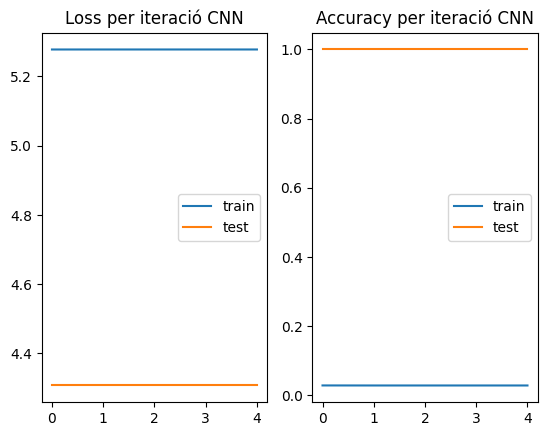

In [11]:
print(type(cpu_running_loss[0]))
print(type(cpu_running_test_loss[0]))
print(type(running_acc[0]))
print(type(running_test_acc_cnn[0]))
plt.subplot(1,2,1)
plt.title("Loss per iteració CNN")
plt.plot(cpu_running_loss, label="train")
plt.plot(cpu_running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()